# Melanoma Detection

This project is meant to be a test in image processing through a neural net and creates a classification algorithm using the topics covered in the Machine Learning Specialization on Coursera. It uses a dataset from kaggle that can be reached here:
https://www.kaggle.com/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection

This model will use greyscale images of different types of skin blemishes to train on.

We first must import the required libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os


from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

We also want to import the dataset. This notebook uses collaboratory's google drive mount to access the data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Parameters and initialization
Here we will initialize the main parameters as well as some hyperparameters so we can easily tune the model. Here we will also initialize some model settings such as the optimizer, loss and metrics

In [3]:
LEARNING_RATE = 0.01
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = (500,500)
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["Accuracy"]


### Data Setup

Using the dataset we will now setup the different data spreads



In [4]:
train_dataset = image_dataset_from_directory(
    directory = "/content/drive/MyDrive/ML/Melanoma/skin-lesions/train/",
    labels = "inferred",
    label_mode = "categorical",
    class_names = ["melanoma", "nevus", "seborrheic_keratosis"],
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True,
    color_mode = "rgb",
    validation_split=0.2,
    subset="training",
    seed=123,
)

valid_dataset = image_dataset_from_directory(
    directory = "/content/drive/MyDrive/ML/Melanoma/skin-lesions/valid/",
    labels = "inferred",
    label_mode = "int",
    class_names = ["melanoma", "nevus", "seborrheic_keratosis"],
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True,
    color_mode = "rgb"
)

test_dataset = image_dataset_from_directory(
    directory = "/content/drive/MyDrive/ML/Melanoma/skin-lesions/test/",
    labels = "inferred",
    label_mode = "int",
    class_names = ["melanoma", "nevus", "seborrheic_keratosis"],
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True,
    color_mode = "rgb"
)





Found 2001 files belonging to 3 classes.
Using 1601 files for training.
Found 150 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


Let's look at some of the data we have in our training set.

TypeError: only integer scalar arrays can be converted to a scalar index

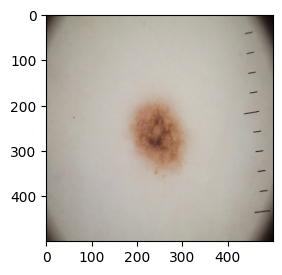

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(images[i].class_name)
        plt.axis("off")

### Data Augmentation & Prefetching

Here we will augment the data slighly to increase the amount of melanoma examples we have in the dataset. We will also use the built in prefetch AUTOTUNE to optimize the data stream.

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2)
        ])

    return data_augmentation

Let's see how this data augmentation works!

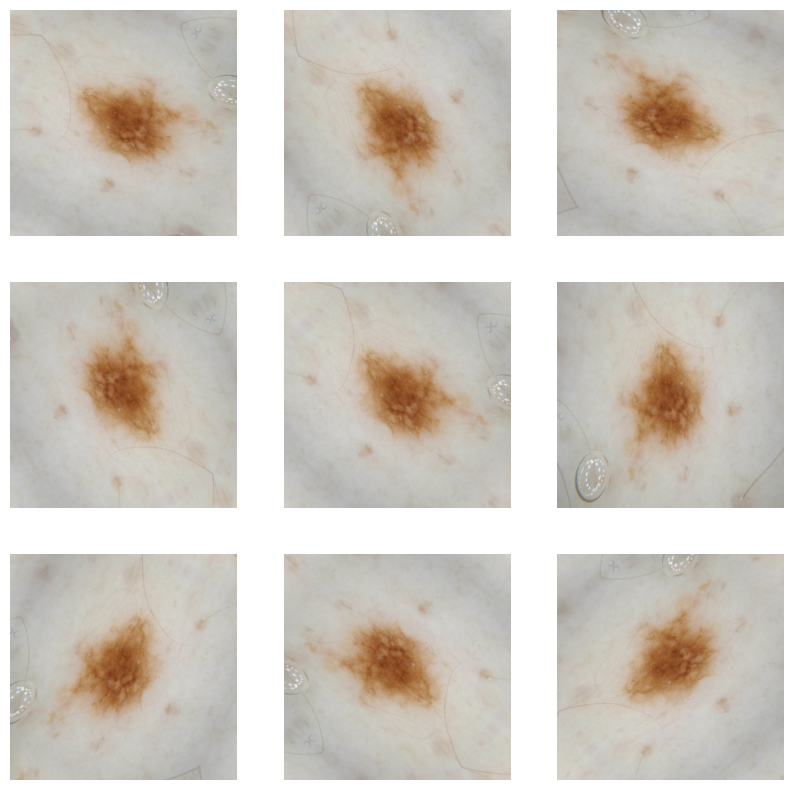

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Building the model

In this portion we will build the model using TensorFlow's functional API. This specific model will be focused on ResNets and the convolutional model.

### Identity Block

This block will be used as the base for most of the network structure. It maintains the shape of the input data across this portion of the network. As shown here:

In [9]:

def identity_block(X, f, filters, initializer = random_uniform):

    #Get the filter sizes
    F1, F2, F3 = filters

    #Keep input value for the residual connection
    X_res = X

    #Main pathway steps

    #Step 1
    X = tf.keras.layers.Conv2D(filters = F1, kernel_size = 1, strides = 1, padding = "valid", kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.Activation("relu")(X)
    #Step 2
    X = tf.keras.layers.Conv2D(filters = F2, kernel_size = f, strides = 1, padding = "same", kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.Activation("relu")(X)
    #Step 3
    X = tf.keras.layers.Conv2D(filters = F3, kernel_size = 1, strides = 1, padding = "valid", kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X)

    #Add the residual connection and use ReLU activation on the sum
    X = tf.keras.layers.Add()([X, X_res])
    X = tf.keras.layers.Activation("relu")(X)

    return X

### Convolutional Block

This block is very similar to the Identity block but it does not maintain the dimensions of the original input. It does have a residual connection but it isn't pure. It is a convolution meant to match the two dimensions when adding them together. This can be seen below:

In [10]:
def convolutional_block(X, f, filters, s = 1, initializer = random_uniform):

    #Get the filter sizes
    F1, F2, F3 = filters

    #Keep input value for the residual connection
    X_res = X

    #Main pathway steps

    #Step 1
    X = tf.keras.layers.Conv2D(filters = F1, kernel_size = 1, strides = s, padding = "valid", kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.Activation("relu")(X)
    #Step 2
    X = tf.keras.layers.Conv2D(filters = F2, kernel_size = f, strides = 1, padding = "same", kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.Activation("relu")(X)
    #Step 3
    X = tf.keras.layers.Conv2D(filters = F3, kernel_size = 1, strides = 1, padding = "valid", kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X)


    #Shortcut Adjustment

    X_res = tf.keras.layers.Conv2D(filters = F3, kernel_size = 1, strides = s, padding = "valid", kernel_initializer = initializer(seed=0))(X_res)
    X_res = tf.keras.layers.BatchNormalization(axis = 3)(X_res)

    #Add the residual connection and use ReLU activation on the sum
    X = tf.keras.layers.Add()([X, X_res])
    X = tf.keras.layers.Activation("relu")(X)

    return X

In [11]:
def ResNet50(input_shape = (500, 500, 3), classes = 3, training=False):

    X_input = tf.keras.layers.Input(input_shape)

    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)

    X = tf.keras.layers.Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)

    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)

    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)

    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = tf.keras.layers.AveragePooling2D()(X)

    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(3, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    model = Model(inputs = X_input, outputs = X)

    return model

In [12]:
tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape = (500, 500, 3), classes = 3)
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 506, 506, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 250, 250, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 250, 250, 64)         256       ['conv2d[0][0]']          

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.fit(train_dataset, epochs = 20, batch_size = 32)

Epoch 1/20
51/51 [==============================] - 587s 11s/step - loss: 16.0141 - accuracy: 0.5234
Epoch 2/20
51/51 [==============================] - 568s 11s/step - loss: 5.8552 - accuracy: 0.5615
Epoch 3/20
51/51 [==============================] - 566s 11s/step - loss: 5.6767 - accuracy: 0.5284
Epoch 4/20
51/51 [==============================] - 568s 11s/step - loss: 3.3906 - accuracy: 0.6015
Epoch 5/20
51/51 [==============================] - 567s 11s/step - loss: 1.4496 - accuracy: 0.6765
Epoch 6/20
51/51 [==============================] - 565s 11s/step - loss: 1.3130 - accuracy: 0.6727
Epoch 7/20
51/51 [==============================] - 566s 11s/step - loss: 1.3211 - accuracy: 0.6733
Epoch 8/20
51/51 [==============================] - 564s 11s/step - loss: 1.7913 - accuracy: 0.6290
Epoch 9/20
51/51 [==============================] - 565s 11s/step - loss: 1.7362 - accuracy: 0.5965
Epoch 10/20
51/51 [==============================] - 564s 11s/step - loss: 1.4045 - accuracy: 0.677